In [1]:
import pandas as pd
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import wcag_contrast_ratio as contrast
from matplotlib.colors import to_rgb

# Loading the dummy CDR into a database

In [2]:
# read the dumm CDR
cdr = pd.read_csv("dummy_data/cdr.csv")

# create in-memory database
db = sqlite3.connect(":memory:")

# drop the cdr table if already exists
db.execute("DROP TABLE IF EXISTS cdr")

# load dummy CDR to the in-memory database
cdr.to_sql("cdr", db)

2279095

# Executing the queries

Please note that this notebook uses sqlite, but in the study PostgreSQL was used. The PostgreSQL dialects of these queries are also included in this repository.

## Device Activity

```sql
SELECT
    device_id,
    count(*) AS activity_count
FROM
    cdr
WHERE
    timestamp >= '2017-04-01 00:00:00'
AND
    timestamp < '2017-04-30 24:00:00'
GROUP BY
    device_id
ORDER BY
    device_id
```

In [3]:
with open("activity_statistics/device_activity.sqlite.sql") as fp:
    device_activity_sql = fp.read()

device_activity = pd.read_sql(device_activity_sql, db)


In [4]:
def prepare_count_data(df):
    cat1 = df[df["activity_count"] == 1]
    cat2 = df[(df["activity_count"] > 1) & (df["activity_count"] < 10)]
    cat3 = df[(df["activity_count"] >= 10) & (df["activity_count"] < 100)]
    cat4 = df[(df["activity_count"] >= 100) & (df["activity_count"] < 1000)]
    cat5 = df[df["activity_count"] >= 1000]

    cats = [len(cat1), len(cat2), len(cat3), len(cat4), len(cat5)]
    cats_r = [len(cat1)/len(df), len(cat2)/len(df), len(cat3)/len(df),
              len(cat4)/len(df), len(cat5)/len(df)]
    trafs = [cat1["activity_count"].sum(), cat2["activity_count"].sum(),
             cat3["activity_count"].sum(), cat4["activity_count"].sum(),
             cat5["activity_count"].sum()]
    records = df["activity_count"].sum()

    trafs_r = [cat1["activity_count"].sum()/records,
               cat2["activity_count"].sum()/records,
               cat3["activity_count"].sum()/records,
               cat4["activity_count"].sum()/records,
               cat5["activity_count"].sum()/records]

    return cats, cats_r, trafs, trafs_r


def plot_count(cats, cats_r, trafs, trafs_r, ratio_pos_left, ratio_pos_right):
    labels = ["One record",
              "Less than 10 records",
              "Less than 100 records",
              "Less than 1000 records",
              "More than 1000 records"]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharey=True)
    bars_t = axs[0].barh(range(len(trafs)), trafs, color=sns.color_palette("BrBG", 5),
                         edgecolor="#3d3d3d")
    bars_c = axs[1].barh(range(len(cats)), cats, color=sns.color_palette("BrBG", 5),
                         edgecolor="#3d3d3d")

    axs[0].yaxis.tick_right()
    axs[0].invert_yaxis()
    axs[0].set_xscale('log')
    axs[0].invert_xaxis()
    axs[0].set_yticks(range(len(labels)))
    axs[0].set_yticklabels(labels, fontsize="small", ha="center",
                           position=(1.19, 0))
    fig.subplots_adjust(wspace=0.425)
    # "Ratio of SIM cards\nin categories"
    axs[0].set_xlabel("Number of activity records")
    # "Ratio of records\ngenerated by\nthe SIM cards\nin each category"
    axs[1].set_xlabel("Number of SIM cards")

    axs[1].get_xaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ","))
    )

    for i, (bar, p, v) in enumerate(zip(bars_c, cats_r, cats)):
        r, g, b, _ = bar.get_facecolor()
        contr = contrast.rgb((r, g, b), to_rgb("#2d2d2d"))
        text_color = "#2d2d2d"
        if v > ratio_pos_left and contr < 4:
            text_color = "white"
        axs[1].text(ratio_pos_right, i, f"{p*100:0.2f}%", ha="left",
                    va="center", color=text_color, fontsize="large")
    for i, (bar, p, v) in enumerate(zip(bars_t, trafs_r, trafs)):
        r, g, b, _ = bar.get_facecolor()
        contr = contrast.rgb((r, g, b), to_rgb("#2d2d2d"))
        text_color = "#2d2d2d"
        if v > ratio_pos_left and contr < 4:
            text_color = "white"
        axs[0].text(ratio_pos_left, i, f"{p*100:0.2f}%", ha="right",
                    va="center", color=text_color, fontsize="large")

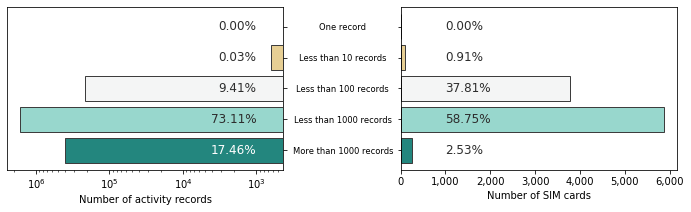

In [5]:
plot_count(*prepare_count_data(device_activity), ratio_pos_left=1000, ratio_pos_right=1000)

## Device Daily Activity

```sql
SELECT
    device_id,
    count(DISTINCT date(timestamp)) AS active_days
FROM
    cdr
WHERE
    timestamp >= '2017-04-01 00:00:00'
AND
    timestamp < '2017-04-30 24:00:00'
GROUP BY
    device_id
ORDER BY
    device_id
```

In [6]:
with open("activity_statistics/device_active_days.sqlite.sql") as fp:
    device_active_days_sql = fp.read()

device_active_days = pd.read_sql(device_active_days_sql, db)

In [7]:
def prepare_daily_data(df, df_count):

    cat1 = df[df["active_days"] == 1]
    cat2 = df[(df["active_days"] > 1) & (df["active_days"] < 7)]
    cat3 = df[(df["active_days"] >= 7) & (df["active_days"] < 14)]
    cat4 = df[(df["active_days"] >= 14) & (df["active_days"] < 21)]
    cat5 = df[(df["active_days"] >= 21) & (df["active_days"] < 28)]
    cat6 = df[(df["active_days"] >= 28)]

    cats = [len(cat1), len(cat2), len(cat3), len(cat4), len(cat5), len(cat6)]
    cats_r = [len(cat1)/len(df), len(cat2)/len(df), len(cat3)/len(df),
              len(cat4)/len(df), len(cat5)/len(df), len(cat6)/len(df)]

    traf_cat1 = df_count[df_count["device_id"].isin(cat1["device_id"])]
    traf_cat2 = df_count[df_count["device_id"].isin(cat2["device_id"])]
    traf_cat3 = df_count[df_count["device_id"].isin(cat3["device_id"])]
    traf_cat4 = df_count[df_count["device_id"].isin(cat4["device_id"])]
    traf_cat5 = df_count[df_count["device_id"].isin(cat5["device_id"])]
    traf_cat6 = df_count[df_count["device_id"].isin(cat6["device_id"])]
    trafs = [traf_cat1["activity_count"].sum(),
             traf_cat2["activity_count"].sum(),
             traf_cat3["activity_count"].sum(),
             traf_cat4["activity_count"].sum(),
             traf_cat5["activity_count"].sum(),
             traf_cat6["activity_count"].sum()]
    records = df_count["activity_count"].sum()
    trafs_r = [traf_cat1["activity_count"].sum()/records,
               traf_cat2["activity_count"].sum()/records,
               traf_cat3["activity_count"].sum()/records,
               traf_cat4["activity_count"].sum()/records,
               traf_cat5["activity_count"].sum()/records,
               traf_cat6["activity_count"].sum()/records]
    return cats, cats_r, trafs, trafs_r


def plot_day_count(cats, cats_r, trafs, trafs_r, ratio_pos_left, ratio_pos_right):
    labels = ["One day", "One to 7 days", "7 to 14 days",
              "14 to 21 days", "21 to 28 days", "At least 28 days"]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharey=True)
    bars_t = axs[0].barh(range(len(trafs)), trafs, color=sns.color_palette("BrBG", 6),
                         edgecolor="#2d2d2d")
    bars_c = axs[1].barh(range(len(cats)), cats, color=sns.color_palette("BrBG", 6),
                         edgecolor="#2d2d2d")

    axs[0].yaxis.tick_right()
    axs[0].invert_yaxis()
    axs[0].set_xscale('log')
    axs[0].invert_xaxis()
    axs[0].set_yticks(range(len(labels)))
    axs[0].set_yticklabels(labels, fontsize="small", ha="center",
                           position=(1.13, 0))
    fig.subplots_adjust(wspace=0.3)
    # "Ratio of SIM cards\nin categories"
    axs[0].set_xlabel("Number of activity records")
    # "Ratio of records\ngenerated by\nthe SIM cards\nin each category"
    axs[1].set_xlabel("Number of SIM cards")

    axs[1].set_xticks(range(0, 400001, 100000))
    axs[1].get_xaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ","))
    )

    for i, (bar, p, v) in enumerate(zip(bars_c, cats_r, cats)):
        r, g, b, _ = bar.get_facecolor()
        contr = contrast.rgb((r, g, b), to_rgb("#2d2d2d"))
        text_color = "#2d2d2d"
        if v > ratio_pos_right and contr < 4:
            text_color = "white"
        axs[1].text(ratio_pos_right, i, f"{p*100:0.2f}%", ha="left",
                    va="center", color=text_color, fontsize="large")
    for i, (bar, p, v) in enumerate(zip(bars_t, trafs_r, trafs)):
        r, g, b, _ = bar.get_facecolor()
        contr = contrast.rgb((r, g, b), to_rgb("#2d2d2d"))
        text_color = "#2d2d2d"
        if v > ratio_pos_left and contr < 4:
            text_color = "white"
        axs[0].text(ratio_pos_left, i, f"{p*100:0.2f}%", ha="right",
                    va="center", color=text_color, fontsize="large")

    # return fig

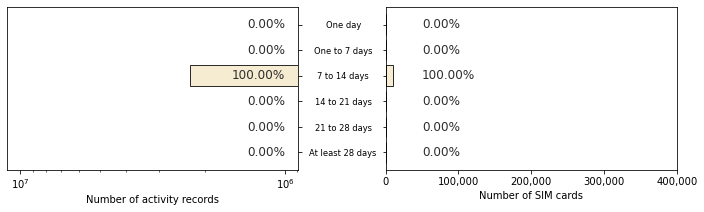

In [8]:
plot_day_count(*prepare_daily_data(device_active_days, device_activity), ratio_pos_left=1000000, ratio_pos_right=50000)